In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm


In [2]:
def background_annulus(data, mask, aperture_x, aperture_y, r_in=25, r_out=45):#r_in=30
    """Measure background in an annulus."""
    
    masked_data = np.ma.array(data=data, mask=mask != 0)
    masked_data = masked_data.filled(fill_value=0)

    center = (aperture_x, aperture_y)
    annulus_apertures = CircularAnnulus(center, r_in=r_in, r_out=r_out)
    masks = annulus_apertures.to_mask(method='center')

    cutout_data = masks.cutout(masked_data)

    clip_annulus_array = sigma_clip(cutout_data[cutout_data != 0], sigma=3, maxiters=2)

    S = pd.Series()
    S['annulus_mean'] = np.ma.mean(clip_annulus_array)
    S['annulus_median'] = np.ma.median(clip_annulus_array)
    S['annulus_std'] = np.ma.std(clip_annulus_array)
    S['annulus_samples'] = np.ma.count(clip_annulus_array)

    return S

def flux_elliptical(image, mask, aperture_x, aperture_y, aperture_theta, aperture_a, aperture_b):
    """Measure the flux withing an elliptical aperture."""
    
    PIXEL_SCALE = 0.263
    theta = -aperture_theta * np.pi / 180.
    a = aperture_a / PIXEL_SCALE
    b = aperture_b / PIXEL_SCALE

    center = (aperture_x, aperture_y)
    source_aperture = EllipticalAperture(center, a, b, theta)

    xmask = mask != 0
    raw_flux = aperture_photometry(image, source_aperture, mask=xmask)
   
    S = pd.Series()
    S['raw_flux'] = float(raw_flux['aperture_sum'][0])
    S['area'] = source_aperture.area
    
    return S

def cal_calerror(sig_src,sig_zp,zp,f_src):
    sig_cal = np.sqrt(sig_src**2 * sig_zp**2 + sig_src**2 * zp**2 + sig_zp**2 * f_src**2)
    return sig_cal

def cal_fcal(f_src,zp):
    f_cal = f_src * zp
    return f_cal

def creat_stamps(image, sources):
    y = math.floor(sources['aperture_x'].values[0])
    x = math.floor(sources['aperture_y'].values[0])
    #y = math.floor(sources['aperture_x'])
    #x = math.floor(sources['aperture_y'])
    x_start = max((x - cutout_size), 0)
    x_end = min((x + cutout_size), image.shape[0])
    y_start = max((y - cutout_size), 0)
    y_end = min((y + cutout_size), image.shape[1])

    stamps = image[x_start:x_end, y_start:y_end]
    return stamps

def photometry_oneimage(image, mask, aperture_x, aperture_y, aperture_theta, aperture_a, aperture_b):
    
    S1 = background_annulus(image, mask, aperture_x, aperture_y)
    S2 = flux_elliptical(image, mask, aperture_x, aperture_y, aperture_theta, aperture_a, aperture_b)

    flux_obs = S2['raw_flux'] - S2['area'] * S1['annulus_mean']
    return flux_obs

def generate_mask(size_data, image):

    num_sample = int(size_data[0] * size_data[1] * (1 - ratio))
    mask = np.ones(size_data)
    output = image

    for ich in range(size_data[2]):
        idy_msk = np.random.randint(0, size_data[0], num_sample)
        idx_msk = np.random.randint(0, size_data[1], num_sample)

        idy_neigh = np.random.randint(-size_window[0] // 2 + size_window[0] % 2, size_window[0] // 2 + size_window[0] % 2, num_sample)
        idx_neigh = np.random.randint(-size_window[1] // 2 + size_window[1] % 2, size_window[1] // 2 + size_window[1] % 2, num_sample)

        idy_msk_neigh = idy_msk + idy_neigh
        idx_msk_neigh = idx_msk + idx_neigh

        idy_msk_neigh = idy_msk_neigh + (idy_msk_neigh < 0) * size_data[0] - (idy_msk_neigh >= size_data[0]) * size_data[0]
        idx_msk_neigh = idx_msk_neigh + (idx_msk_neigh < 0) * size_data[1] - (idx_msk_neigh >= size_data[1]) * size_data[1]

        id_msk = (idy_msk, idx_msk, ich)
        id_msk_neigh = (idy_msk_neigh, idx_msk_neigh, ich)

        output[id_msk] = image[id_msk_neigh]
        mask[id_msk] = 0.0

    return output, mask

In [3]:
denoisedgalaxyafter2223 = pd.read_csv('/data/aai/scratch/jchan/denoise/PAUS/output_save/modify_pn2v/denoisedgalaxy22-23model1.csv')
denoisedgalaxyafter1721 = pd.read_csv('/data/aai/scratch/jchan/denoise/PAUS/output_save/modify_pn2v/denoisedgalaxy17-21model1.csv')
denoisedgalaxyafter2122 = pd.read_csv('/data/aai/scratch/jchan/denoise/PAUS/output_save/modify_pn2v/denoisedgalaxy21-22model1.csv')

In [4]:
denoisedgalaxyafter = pd.concat([denoisedgalaxyafter1721, denoisedgalaxyafter2122,
                                 denoisedgalaxyafter2223], axis=0, ignore_index=True)

In [5]:
denoisedgalaxyafter['flux_ca_error'] = cal_calerror(denoisedgalaxyafter['flux_error'],denoisedgalaxyafter['zp_error'],denoisedgalaxyafter['zp'],denoisedgalaxyafter['flux_obs'])
denoisedgalaxyafter['flux_ca'] = cal_fcal(denoisedgalaxyafter['flux_obs'],denoisedgalaxyafter['zp'])

denoisedgalaxyafter['flux_ca_error_obs'] = cal_calerror(denoisedgalaxyafter['flux_error'],denoisedgalaxyafter['zp_error'],denoisedgalaxyafter['zp'],denoisedgalaxyafter['flux_obs_denoised'])
denoisedgalaxyafter['flux_ca_obs'] = cal_fcal(denoisedgalaxyafter['flux_obs_denoised'],denoisedgalaxyafter['zp'])

denoisedgalaxyafter['snr'] = denoisedgalaxyafter['flux_ca_obs'] / (denoisedgalaxyafter['area'] * denoisedgalaxyafter['annulus_std'])

combb = pd.merge(denoisedgalaxyafter,denoisedgalaxyafter,on = ['ref_id','filter'])
combb['df1'] = (combb['flux_ca_x'] - combb['flux_ca_y'])/np.sqrt(combb['flux_ca_error_x']**2 + combb['flux_ca_error_y']**2)
combb['df2'] = (combb['flux_ca_obs_x'] - combb['flux_ca_obs_y'])/np.sqrt(combb['flux_ca_error_x']**2 + combb['flux_ca_error_y']**2)
combb = combb[combb.image_id_x != combb.image_id_y]

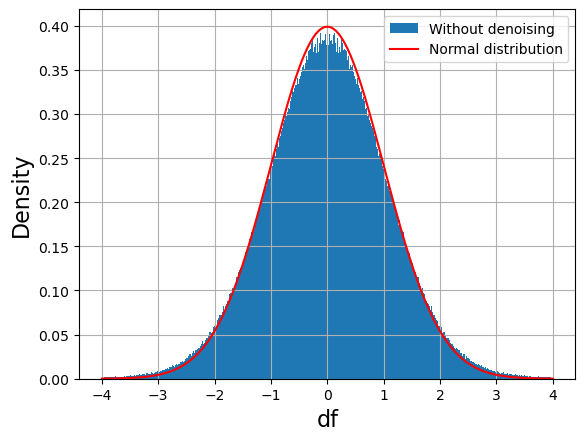

In [6]:
denoisedgalaxyafter['flux_ca_error'] = cal_calerror(denoisedgalaxyafter['flux_error'],denoisedgalaxyafter['zp_error'],denoisedgalaxyafter['zp'],denoisedgalaxyafter['flux_obs'])
denoisedgalaxyafter['flux_ca'] = cal_fcal(denoisedgalaxyafter['flux_obs'],denoisedgalaxyafter['zp'])

comb = pd.merge(denoisedgalaxyafter,denoisedgalaxyafter,on = ['ref_id','filter'])
comb['df'] = (comb['flux_ca_x'] - comb['flux_ca_y'])/np.sqrt(comb['flux_ca_error_x']**2 + comb['flux_ca_error_y']**2)
comb = comb[comb.image_id_x != comb.image_id_y]

comb.df.hist(bins=np.linspace(-4, 4,500), density=True,label = 'Without denoising')

x = np.linspace(-4, 4, 33266)
y = norm.pdf(x)
plt.plot(x, y,color='red',label = 'Normal distribution')
plt.xlabel('df', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(fontsize=10)
#plt.savefig("/data/aai/scratch/jchan/denoise/PAUS/output_save/histwithoutdenoising.pdf",
 #           format="pdf", bbox_inches="tight")

In [7]:
combined_NB705 = pd.read_csv('/data/aai/scratch/jchan/denoise/PAUS/output_save/denoisedgalaxyafter4.csv')

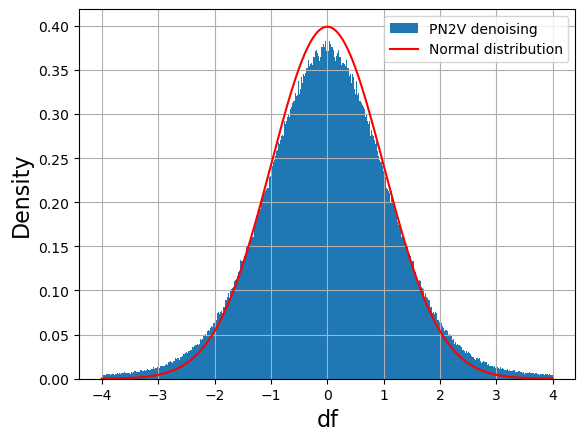

In [8]:
combb705 = pd.merge(combined_NB705,combined_NB705,on = ['ref_id','filter'])
combb705['df1'] = (combb705['flux_ca_x'] - combb705['flux_ca_y'])/np.sqrt(combb705['flux_ca_error_x']**2 + combb705['flux_ca_error_y']**2)
combb705['df2'] = (combb705['flux_ca_obs_x'] - combb705['flux_ca_obs_y'])/np.sqrt(combb705['flux_ca_error_x']**2 + combb705['flux_ca_error_y']**2)
combb705 = combb705[combb705.image_id_x != combb705.image_id_y]

combb705.df2.hist(bins=np.linspace(-4, 4,500), density=True,label = 'PN2V denoising')

x = np.linspace(-4, 4, 33266)
y = norm.pdf(x)
plt.plot(x, y,color='red',label = 'Normal distribution')
plt.xlabel('df', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(fontsize=10)
#plt.savefig("/data/aai/scratch/jchan/denoise/PAUS/output_save/histPN2Vdenoising.pdf",
          #  format="pdf", bbox_inches="tight")

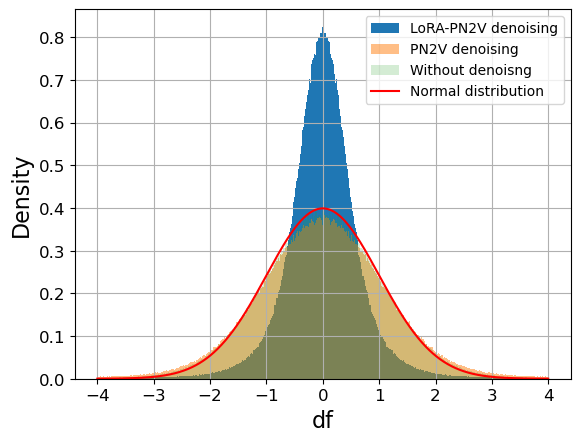

In [9]:
combb.df2.hist(bins=np.linspace(-4, 4,500), density=True,label='LoRA-PN2V denoising')
combb705.df2.hist(bins=np.linspace(-4, 4,500), density=True,alpha = 0.5, label = 'PN2V denoising')
comb.df.hist(bins=np.linspace(-4, 4,500), density=True,alpha = 0.2, label = 'Without denoisng')

x = np.linspace(-4, 4, 33266)
y = norm.pdf(x)
plt.plot(x, y,color='red',label = 'Normal distribution')
plt.legend(fontsize=10)
plt.xlabel('df', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
#plt.savefig("/data/aai/scratch/jchan/denoise/PAUS/output_save/loradf.pdf",
            #format="pdf", bbox_inches="tight")

<Axes: >

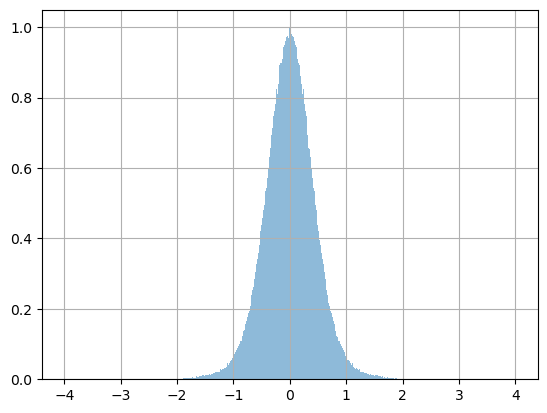

In [29]:
combbfaint = combb[(combb['I_auto_x'] >22)]
combbfaint.df2.hist(bins=np.linspace(-4, 4,500), density=True,alpha = 0.5)

In [24]:
sigma68 = (np.percentile(combbfaint.df2, 84) - np.percentile(combbfaint.df2, 16)) / 2
sigma68

0.4149695206506214

In [10]:
sigma68 = (np.percentile(combb.df2, 84) - np.percentile(combb.df2, 16)) / 2
sigma68

0.5289985452110069

In [10]:
denoisedgalaxyafter[['flux_obs_denoised', 'flux_obs']]

,flux_obs_denoised,flux_obs
0,14.657958,20.789509
1,33.962083,36.065938
2,3.756208,5.032835
3,55.528674,54.860167
4,2.982925,3.755624
...,...,...
295691,3.305679,-0.044425
295692,1.856821,0.591041
295693,2.311497,0.798493
295694,1.833406,1.844851


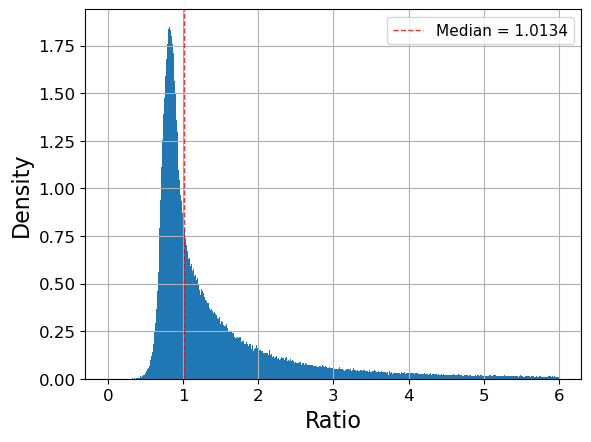

In [28]:
flux_ratio_df = pd.DataFrame({
    'flux_ratio': denoisedgalaxyafter['flux_obs_denoised'] / denoisedgalaxyafter['flux_obs']})

median_value = 1.013448

flux_ratio_df.flux_ratio.hist(bins=np.linspace(0, 6, 500), density=True)
plt.xlabel('Ratio', fontsize=16)
plt.ylabel('Density', fontsize=16)

plt.axvline(median_value, color='red', linestyle='--', linewidth=1, 
           alpha=0.8, label=f'Median = {median_value:.4f}')

plt.legend(fontsize=11)
plt.tick_params(axis='both', which='major', labelsize=12)
#plt.savefig("/data/aai/scratch/jchan/denoise/PAUS/output_save/loraratio.pdf",
            #format="pdf", bbox_inches="tight")

In [22]:
filtered = flux_ratio_df[(flux_ratio_df['flux_ratio'] > 0)&(flux_ratio_df['flux_ratio'] <5)]
filtered.median()

flux_ratio    1.013448
dtype: float64

In [ ]:
combb.df2.hist(bins=np.linspace(-4, 4,500), density=True,label='LoRA-PN2V denoising')
combb705.df2.hist(bins=np.linspace(-4, 4,500), density=True,alpha = 0.5, label = 'PN2V denoising')
comb.df.hist(bins=np.linspace(-4, 4,500), density=True,alpha = 0.2, label = 'Without denoisng')

x = np.linspace(-4, 4, 33266)
y = norm.pdf(x)
plt.plot(x, y,color='red',label = 'Normal distribution')
plt.legend(fontsize=10)
plt.xlabel('df', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
#plt.savefig("/data/aai/scratch/jchan/denoise/PAUS/output_save/loradf.pdf",
            #format="pdf", bbox_inches="tight")

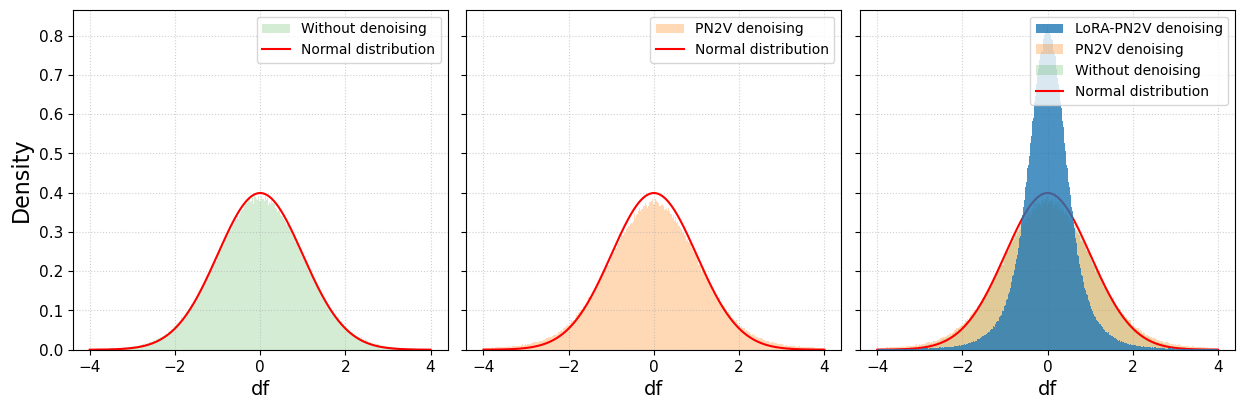

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

x_range = np.linspace(-4, 4, 500)
x_curve = np.linspace(-4, 4, 33266)
y_curve = norm.pdf(x_curve)

axes[0].hist(comb.df, bins=x_range, density=True, alpha=0.2, 
             label='Without denoising', color='tab:green')
axes[0].plot(x_curve, y_curve, color='red', label='Normal distribution')
#axes[0].set_title("(a) Without denoising", y=-0.2) # 标题放在图下方

axes[1].hist(combb705.df2, bins=x_range, density=True, alpha=0.3, 
             label='PN2V denoising', color='tab:orange')
axes[1].plot(x_curve, y_curve, color='red', label='Normal distribution')
#axes[1].set_title("(b) PN2V denoising", y=-0.2)

axes[2].hist(combb.df2, bins=x_range, density=True, alpha=0.8, 
             label='LoRA-PN2V denoising', color='tab:blue', zorder=3)
axes[2].hist(combb705.df2, bins=x_range, density=True, alpha=0.3, 
             label='PN2V denoising', color='tab:orange', zorder=2)
axes[2].hist(comb.df, bins=x_range, density=True, alpha=0.2, 
             label='Without denoising', color='tab:green', zorder=1)

axes[2].plot(x_curve, y_curve, color='red', label='Normal distribution')
#axes[2].set_title("(c) LoRA-PN2V denoising", y=-0.2)

for ax in axes:
    ax.set_xlabel('df', fontsize=14)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.tick_params(axis='both', labelsize=11)
    # 每个子图都加图例，或者只在最后一张加，根据需求调整
    ax.legend(fontsize=10, loc='upper right')

# 设置最左侧图的 Y 轴标签
axes[0].set_ylabel('Density', fontsize=16)

# 关键控制：调整子图间距。wspace=0.05 表示间距仅为子图宽度的 5%
plt.subplots_adjust(wspace=0.05, bottom=0.2)

#plt.savefig("/data/aai/scratch/jchan/denoise/PAUS/output_save/hists.pdf",
  #          format="pdf", bbox_inches="tight")
plt.show()

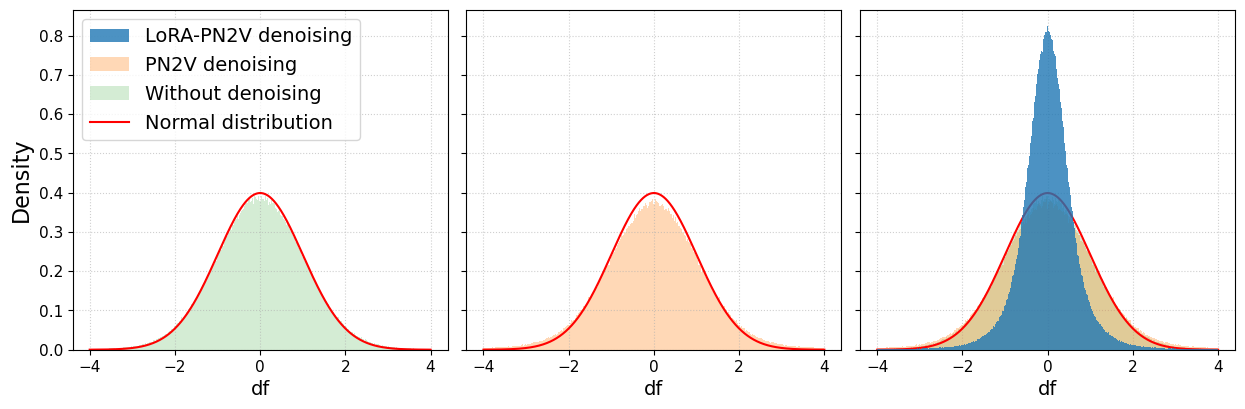

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

x_range = np.linspace(-4, 4, 500)
x_curve = np.linspace(-4, 4, 33266)
y_curve = norm.pdf(x_curve)

# --- 图 (a): Without denoising ---
axes[0].hist(comb.df, bins=x_range, density=True, alpha=0.2, 
             label='Without denoising', color='tab:green')
axes[0].plot(x_curve, y_curve, color='red', label='Normal distribution')

# --- 图 (b): PN2V denoising ---
axes[1].hist(combb705.df2, bins=x_range, density=True, alpha=0.3, 
             label='PN2V denoising', color='tab:orange')
axes[1].plot(x_curve, y_curve, color='red', label='Normal distribution')

# --- 图 (c): LoRA-PN2V denoising (包含所有元素用于提取图例) ---
axes[2].hist(combb.df2, bins=x_range, density=True, alpha=0.8, 
             label='LoRA-PN2V denoising', color='tab:blue', zorder=3)
axes[2].hist(combb705.df2, bins=x_range, density=True, alpha=0.3, 
             label='PN2V denoising', color='tab:orange', zorder=2)
axes[2].hist(comb.df, bins=x_range, density=True, alpha=0.2, 
             label='Without denoising', color='tab:green', zorder=1)
axes[2].plot(x_curve, y_curve, color='red', label='Normal distribution')

# --- 核心修改：管理图例 ---
# 从包含所有信息的 axes[2] 中提取图例句柄和标签
handles, labels = axes[2].get_legend_handles_labels()

# 将完整的图例放置在第一张图 (axes[0])
# 使用 loc='upper left' 通常可以避开中间的波峰
axes[0].legend(handles, labels, fontsize=14, loc='upper left', frameon=True)

for ax in axes:
    ax.set_xlabel('df', fontsize=14)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.tick_params(axis='both', labelsize=11)
    # 移除原先循环中的 ax.legend()

axes[0].set_ylabel('Density', fontsize=16)

plt.subplots_adjust(wspace=0.05, bottom=0.2)
plt.savefig("/data/aai/scratch/jchan/denoise/PAUS/output_save/hists.pdf",
            format="pdf", bbox_inches="tight")
plt.show()